# Effect of Data Scaling on K-NN Classification


In this notebook we investigate the impact of data scaling on the performance of a K-NN classifier. We scale the features via a process called **Standardization**.

Standardization is a useful technique to transform features with a Gaussian distribution and differing means and standard deviations to a standard Gaussian distribution with a mean of 0 and a standard deviation of 1.

We will use Scikit-Learn's (sklearn.preprocessing) **StandardScaler** for this purpose. Another technique is to use **sklearn.preprocessing.scale**.


## Tasks

We will perform two tasks.
- Task 1: Perform K-NN classification using non-standardized data
- Task 2: Perform K-NN classification using standardized data

Then, we will compare the performance of both classifications by using various performance measures as well as decision boundaries.


### Note: 

Data standardization requirement varies depending on the type of distance metric being used by the model. 
- Minkowski: Standardize the data during preprocessing
- Mahalanobis: No need to Standardize the data during preprocessing

In this notebook we use the **Minkowski** distance metric. Thus, we standardize the data during preprocessing.


In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Dataset

We create a synthetic dataset that consists of datapoints from two classes (class 0 and 1).

In this binary data, variance along dimension $x_2$ is larger as compared to the variance along the dimension $x_1$.

(200, 2)
(250, 2)


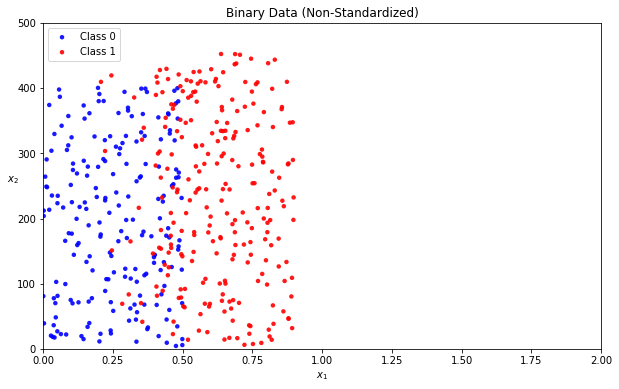

In [2]:
np.random.seed(43)

m0 = 200  # no. of training examples for class 0


# Generate class 0 data points randomly from a uniform distribution
#    Here a & b are 2 dimensions for each data (feature) point
a = 0.5 *np.random.rand(m0,1)
b = 2 + a + 400*np.random.rand(m0,1)


# Concatenate the 2 dimensions of each feature to create the data matrix for class 0 
X0 = np.concatenate((a, b), axis=1)

# Create the target vector for class 0 (target is coded with zeros)
X0_target = np.zeros((m0,), dtype=np.int).reshape(-1, 1)

print(X0.shape)


m1 = 200  # no. of training examples for class 1


# Generate class 1 data points randomly from a uniform distribution
#    Here c & d are 2 dimensions for each data (feature) point
c = 0.4 + 0.5 *np.random.rand(m1,1)
d = 2 + c + 450*np.random.rand(m1,1)

# Concatenate the 2 dimensions of each feature to create the data matrix for class 1
X1a = np.concatenate((c, d), axis=1)



# Add 50 more training examples for class 1

e = 0.2 + 0.5 *np.random.rand(50,1)
f = 23 + e + 400*np.random.rand(50,1)
X1b = np.concatenate((e, f), axis=1)

# Create the target vector for class 1 (target is coded with ones)
X1_target = np.ones((m1+50,), dtype=np.int).reshape(-1, 1)


# All training examples for class 1
X1 = np.append(X1a, X1b, axis=0)
print(X1.shape)


# All training examples for class 0 and 1
X = np.append(X0, X1, axis=0)

# All target values for class 0 & 1
y = np.concatenate((X0_target, X1_target), axis=0)



# Draw a scatter plot
fig = plt.figure(figsize=(10, 6))
plt.scatter(X0[:, 0], X0[:, 1],alpha=0.9, c="blue", edgecolors='none', s=20, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1],alpha=0.9, c="red", edgecolors='none', s=20, label="Class 1")
plt.xlim(0,2)
plt.ylim(0,500)
plt.title("Binary Data (Non-Standardized)")
plt.legend(loc=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.show()


# Feature Scaling

We observe that there is a large variation in the scale (unit) of the features (dimensions). Thus, we need to re-scale the features.

The Standardization technique is used to scale the features along their respective dimensions as well as normalize the data to center it around the mean.

Feature scaling is required when we use the **Minkowski** distance metric.

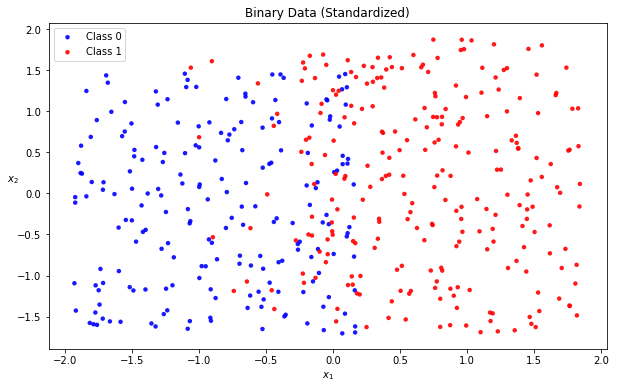

In [3]:
# Two techniques for scaling the data matrix

# Technique 1
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)


# Technique 2
#X = scale(X)

# Get the datapoints from each class to plot them
X0_scaled = X_std[0:200, :]
X1_scaled = X_std[200:, :]

# Draw a scatter plot
fig = plt.figure(figsize=(10, 6))
plt.scatter(X0_scaled[:, 0], X0_scaled[:, 1],alpha=0.9, c="blue", edgecolors='none', s=20, label="Class 0")
plt.scatter(X1_scaled[:, 0], X1_scaled[:, 1],alpha=0.9, c="red", edgecolors='none', s=20, label="Class 1")
plt.title("Binary Data (Standardized)")
plt.legend(loc=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.show()


# Create Test and Train Dataset

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

This function splits arrays or matrices into **random** train and test subsets.

For the **reproducibility of the results**, we need to use the same seed for the random number generator. The seed is set by the "random_state" parameter of the split function. 

However, in repeated experiments if we don't want to use the same train and test subsets, then we drop the "random_state" parameter from the funtion.

### Note: Target y

The target y is defined as a 1D vector. The sklearn KNeighborsClassifier model requires the target to be a 1D array. 

We use the numpy.ravel() function to create a flattened array from the 1D vector y.

We create seperate train-test sets for both the non-standardized and the standardized data.

In [4]:
# Convert the target as a 1D array
y = y.ravel()

# Non-standardized Data: Spilt the dataset into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Standardized Data: Spilt the dataset into training and test dataset
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, y, test_size=0.2, random_state=0)

## K-NN Model Selection


A K-NN model is defined by a set of parameters: nearest neighbors (K), distance metric (p), etc. These are called **hyperparameters**. We need to select the best model based on the optimal values of these hyperparameters. This process is called hyperparameter tuning.

The model parameters are known as **hyperparameters** because the values of these parameters are used to control the learning process. By contrast, the values of other parameters are learned. In the K-NN model there is no learning, thus we only tune the hyperparameters to create the optimal model

Hyperparameters are are passed as arguments to the constructor of the estimator classes. We search the hyperparameter space for the best cross validation score.


### Hyperparameter Tuning

The best way to do hyperparameter tuning is to use cross-validation.

We will use Scikit-Learn’s **GridSearchCV** to search the combinations of hyperparameter values that provide the best performance.

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. It will evaluate all the possible combinations of hyperparameter values, using cross-validation. 

We will tune the following hyperparameters of the GridSearchCV model.

- n_neighbors 
- weights 
- p 
    


### GridSearchCV Parameters

Following are the most frequenly used parameters by GridSearchCV.

- estimator : estimator object. This is assumed to implement the scikit-learn estimator interface. Either estimator needs to provide a score function, or scoring must be passed.

- param_grid : Dictionary with parameters names (string) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. This enables searching over any sequence of parameter settings.

- scoring : string, callable, list/tuple, dict or None, default: None

    -- A single string (see The scoring parameter: defining model evaluation rules) or a callable (see Defining your scoring strategy from metric functions) to evaluate the predictions on the test set.


- n_jobs : int or None, optional (default=None). Number of jobs to run in parallel. 

    -- n_jobs= None means 1 unless in a joblib.parallel_backend context. 
   
    -- n_jobs = -1 means using all processors. 

- cv : int. Determines the cross-validation splitting strategy. None, to use the default 3-fold cross validation.

- verbose : integer. Controls the verbosity: the higher, the more messages.


### Note: the scoring function

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use "f1_micro" scoring function. The f1_micro function is the average of the F1 score of each class with weighting depending on the average parameter.

In the binary classification, f1 score function can be used. We may also use the precision, recall, roc_auc functions.



### Note: Experimenting with the Mahalanobis Distance Metric

Note that we cannot use the Mahalanobis distance metric as a parameter for the grid search.

Because for each iteration of the cross-validation, a new train fold is created which requires to compute the inverse of its covariance matrix.

With the sklearn grid search we cannot compute the inverse of the covariance matrix dynamically for each training fold.

Thus, unfortunately, we can't experiment with the Mahalanobis distance metric using the grid search.


## Model Selection: Non-Standardized Data

In [5]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values 
param_grid = {'n_neighbors': np.arange(1,37, 2), 'p': [1, 2, 5,  10, 20, 30, 50, 100], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed:    5.7s


Best Score: 0.669070
Optimal Hyperparameter Values:  {'p': 1, 'n_neighbors': 23, 'weights': 'distance'}


CPU times: user 1.31 s, sys: 118 ms, total: 1.43 s
Wall time: 6.8 s


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    6.8s finished


## Model Selection: Standardized Data

In [6]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values 
param_grid = {'n_neighbors': np.arange(1,37, 2), 'p': [1, 2, 5,  10, 20, 30, 50, 100], 
              'weights': ["uniform", "distance"]}

knn_std_clf = KNeighborsClassifier()

knn_std_cv = GridSearchCV(knn_std_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_std_cv.fit(X_std_train, y_std_train)


params_optimal_std_knn = knn_std_cv.best_params_

print("Best Score: %f" % knn_std_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_std_knn)
print("\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Score: 0.877880
Optimal Hyperparameter Values:  {'p': 1, 'n_neighbors': 35, 'weights': 'uniform'}


CPU times: user 1.22 s, sys: 29.8 ms, total: 1.25 s
Wall time: 4.68 s


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    4.7s finished


## Select The Best Model 

Using the optimal hyperparameter values, create the best model.
Then, fit the model.

## Note on Using Mahalanobis Distance Metric:

Note that the Mahalanobis distance metric works only with the brute force algorithm in sklearn. With this distance metric we tune only the following two hyperparameters.
- weights: "distance", "uniform"
- n_neighbors: int

Also the data should not be standardized before using the Mahalanobis distance metric.

## Optimal Model: Non-Standardized Data

In [7]:
knn = KNeighborsClassifier(**params_optimal_knn)
knn.fit(X_train, y_train) 

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy (non-standardized data): ", train_accuracy_knn)


Training Accuracy (non-standardized data):  1.0


## Optimal Model: Standardized Data

In [8]:
knn_std = KNeighborsClassifier(**params_optimal_std_knn)
knn_std.fit(X_std_train, y_std_train) 

y_std_train_predicted = knn_std.predict(X_std_train)

train_accuracy_std_knn = np.mean(y_std_train_predicted == y_std_train)
print("\nTraining Accuracy (standardized data): ", train_accuracy_std_knn)


Training Accuracy (standardized data):  0.8583333333333333


# Evaluate The Model Using Test Data

The KNeighborsClassifier model has a default "score" function that computes the accuracy of the model.

Often times the accuracy is not a good measure.

We also compute the other performance measures, such as the confusion matrix, precision, recall, and the F1 score for the test data.

## Model Evaluation: Non-Standardized Data

In [9]:
print("Evaluation of the KNN Model: Non-Standardized Data")

# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))

precision = precision_score(y_test, y_test_predicted) 
print("\nPrecision = %f" % precision)

recall = recall_score(y_test, y_test_predicted)
print("Recall = %f" % recall)


f1 = f1_score(y_test, y_test_predicted)
print("F1 Score = %f" % f1)

Evaluation of the KNN Model: Non-Standardized Data

Test Accuracy:  0.6111111111111112

No. of correct predictions (Test): 55/90

Confusion Matrix (Test Data):
 [[21 19]
 [16 34]]

Precision = 0.641509
Recall = 0.680000
F1 Score = 0.660194


## Model Evaluation: Standardized Data

In [10]:
print("Evaluation of the KNN Model: Standardized Data")

# The accuracy of the model
test_accuracy_std_knn = knn_std.score(X_std_test, y_std_test)
print("\nTest Accuracy: ", test_accuracy_std_knn)



# No. of Correct Predictions
y_std_test_predicted = knn_std.predict(X_std_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_std_test_predicted == y_std_test), len(y_std_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_std_test, y_std_test_predicted))

precision_std = precision_score(y_std_test, y_std_test_predicted) 
print("\nPrecision = %f" % precision_std)

recall_std = recall_score(y_std_test, y_std_test_predicted)
print("Recall = %f" % recall_std)


f1_std = f1_score(y_std_test, y_std_test_predicted)
print("F1 Score = %f" % f1_std)


Evaluation of the KNN Model: Standardized Data

Test Accuracy:  0.8555555555555555

No. of correct predictions (Test): 77/90

Confusion Matrix (Test Data):
 [[33  7]
 [ 6 44]]

Precision = 0.862745
Recall = 0.880000
F1 Score = 0.871287


# Function for Plotting Decision Bounday 


To better understand how the K Nearest Neighbors model classifier performs classifiation, we need to **<font color=red size=6> visualize </font>** its decision boundary.


We define the function "decision_boundary_class_colored" to plot the decision boundary. 

In [11]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()
    

# Visualize the Decision Boundary: Non-Standardized Data vs Standardized Data

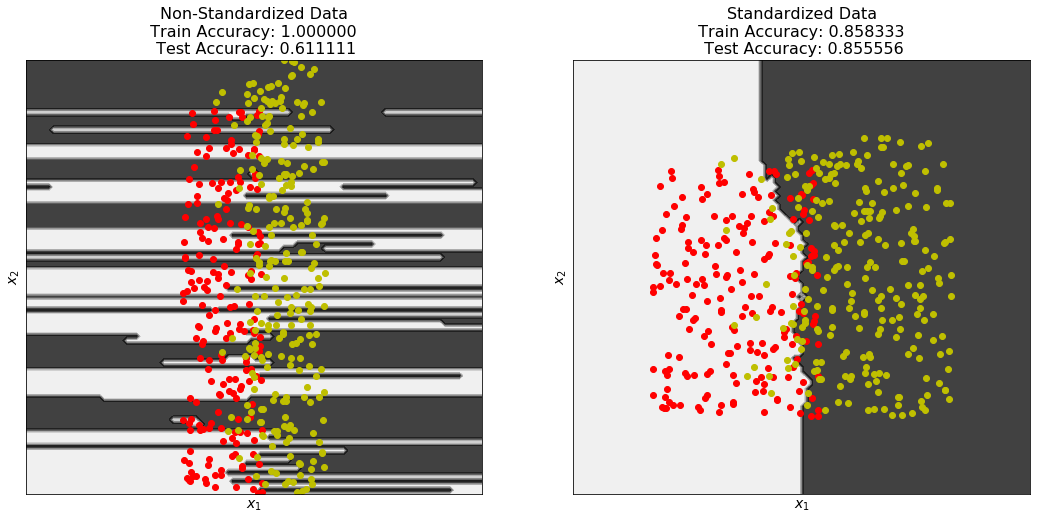

In [12]:
plt.figure(figsize=(18,8))

plt.subplot(121)
decision_boundary_class_colored(knn, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Non-Standardized Data\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_knn, test_accuracy_knn) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(knn_std, X_std, plotDistanceFromHyperplane=False)
plt.plot(X_std[y.ravel()==0, 0], X_std[y.ravel()==0, 1], "ro")
plt.plot(X_std[y.ravel()==1, 0], X_std[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Standardized Data\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_std_knn, test_accuracy_std_knn) , fontsize=16)
plt.xticks(())
plt.yticks(())

plt.show()
